Imports

In [72]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


In [90]:
# ===== CONFIG =====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
EMBED_DIM = 128

BATCH_SIZE = 8
EPOCHS = 10
LR_HEAD = 1e-4
LR_BACKBONE = 1e-5

MARGIN = 0.5
SEED = 42


In [74]:
torch.manual_seed(SEED)
random.seed(SEED)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [75]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


DATASET LOADER

In [76]:
class SketchPhotoTripletDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.pairs = []

        for fname in os.listdir(sketch_dir):
            if not fname.endswith(".jpg"):
                continue

            base_id = fname.replace("-sz1.jpg", "")
            photo_path = os.path.join(photo_dir, base_id + ".jpg")
            sketch_path = os.path.join(sketch_dir, fname)

            if os.path.exists(photo_path):
                self.pairs.append((sketch_path, photo_path))

        assert len(self.pairs) > 0, "No sketch-photo pairs found!"
        print(f"[INFO] Loaded {len(self.pairs)} pairs")

    def __len__(self):
        return len(self.pairs)

    def _load(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return transform(img)

    def __getitem__(self, idx):
        sketch_path, pos_photo_path = self.pairs[idx]

        # Anchor
        anchor = self._load(sketch_path)

        # Positive
        positive = self._load(pos_photo_path)

        # Negative (different identity)
        neg_idx = idx
        while neg_idx == idx:
            neg_idx = random.randint(0, len(self.pairs) - 1)

        _, neg_photo_path = self.pairs[neg_idx]
        negative = self._load(neg_photo_path)

        return anchor, positive, negative


RESNET50 ENCODER

In [77]:
class Encoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()

        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(2048, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = F.normalize(x, p=2, dim=1)
        return x


In [78]:
criterion = nn.TripletMarginLoss(margin=MARGIN)

In [80]:
dataset = SketchPhotoTripletDataset(
    sketch_dir="../dataset/sketches",
    photo_dir="../dataset/photos"
)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

[INFO] Loaded 100 pairs


In [86]:
model = Encoder().to(DEVICE)
# Freeze backbone ONLY
for name, p in model.backbone.named_parameters():
    p.requires_grad = False

# Unfreeze FC explicitly (safety)
for p in model.backbone.fc.parameters():
    p.requires_grad = True

d:\Python\Netra-X\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Netra-X\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
optimizer = torch.optim.Adam(
    model.backbone.fc.parameters(),
    lr=1e-4
)

TRAINING LOOP

In [91]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for anchor, pos, neg in loader:
        anchor = anchor.to(DEVICE)
        pos = pos.to(DEVICE)
        neg = neg.to(DEVICE)

        emb_a = model(anchor)
        emb_p = model(pos)
        emb_n = model(neg)

        loss = criterion(emb_a, emb_p, emb_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}")

Epoch [1/10] Loss: 0.1546
Epoch [2/10] Loss: 0.1253
Epoch [3/10] Loss: 0.1203
Epoch [4/10] Loss: 0.0957
Epoch [5/10] Loss: 0.0591
Epoch [6/10] Loss: 0.0596
Epoch [7/10] Loss: 0.0529
Epoch [8/10] Loss: 0.0405
Epoch [9/10] Loss: 0.0477
Epoch [10/10] Loss: 0.0374


In [92]:
#unfreeze layer
for name, p in model.backbone.named_parameters():
    if "layer4" in name:
        p.requires_grad = True


In [93]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_BACKBONE
)

In [ ]:
## RETRAIN with UNFREEZE LAYERS
EPOCH_2 = 5
for epoch in range(EPOCH_2):
    model.train()
    total_loss = 0

    for anchor, pos, neg in loader:
        anchor = anchor.to(DEVICE)
        pos = pos.to(DEVICE)
        neg = neg.to(DEVICE)

        emb_a = model(anchor)
        emb_p = model(pos)
        emb_n = model(neg)

        loss = criterion(emb_a, emb_p, emb_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{EPOCH_2}] Loss: {avg_loss:.4f}")

Epoch [1/10] Loss: 0.0220
Epoch [2/10] Loss: 0.0307
Epoch [3/10] Loss: 0.0131
Epoch [4/10] Loss: 0.0253
Epoch [5/10] Loss: 0.0183


In [ ]:
#checking freeze layer (DEBUG)

for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.requires_grad)

backbone.fc.weight True
backbone.fc.bias True


In [95]:
model.eval()

a, p, n = next(iter(loader))
a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)

with torch.no_grad():
    ea = model(a)
    ep = model(p)
    en = model(n)

pos_sim = F.cosine_similarity(ea, ep).mean().item()
neg_sim = F.cosine_similarity(ea, en).mean().item()

print("Positive similarity:", pos_sim)
print("Negative similarity:", neg_sim)


Positive similarity: 0.3532409369945526
Negative similarity: -0.07095538079738617


EMBEDDING

In [96]:
import torch
import torch.nn.functional as F

model.eval()

photo_embeddings = []
photo_ids = []

with torch.no_grad():
    for _, photo_path in dataset.pairs:
        img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = transform(img).to(DEVICE)

        emb = model(img.unsqueeze(0))
        photo_embeddings.append(emb.cpu())
        photo_ids.append(photo_path)

photo_embeddings = torch.cat(photo_embeddings)


In [97]:
def match_sketch(sketch_path):
    model.eval()

    img = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = transform(img).to(DEVICE)

    with torch.no_grad():
        sketch_emb = model(img.unsqueeze(0))
        sims = F.cosine_similarity(sketch_emb.cpu(), photo_embeddings)

    best_idx = torch.argmax(sims).item()
    best_photo = photo_ids[best_idx]
    best_score = sims[best_idx].item()

    return best_photo, best_score


Matched Photo: ../dataset/photos\f1-009-01.jpg
Similarity: 0.4607156813144684


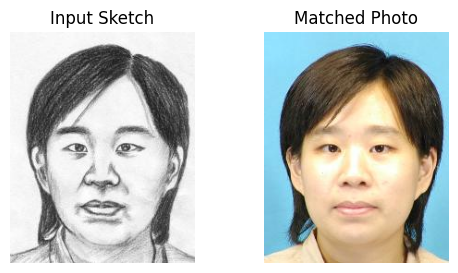

In [120]:
import matplotlib.pyplot as plt

sketch_path = r"..\dataset\sketches\f1-009-01-sz1.jpg"
best_photo, score = match_sketch(sketch_path)

print("Matched Photo:", best_photo)
print("Similarity:", score)

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.title("Input Sketch")
plt.imshow(cv2.cvtColor(cv2.imread(sketch_path), cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Matched Photo")
plt.imshow(cv2.cvtColor(cv2.imread(best_photo), cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


In [121]:
correct = 0

for sketch_path, true_photo_path in dataset.pairs:
    pred_photo, _ = match_sketch(sketch_path)

    if os.path.basename(pred_photo) == os.path.basename(true_photo_path):
        correct += 1

rank1 = correct / len(dataset.pairs)
print("Rank-1 Accuracy:", rank1)


Rank-1 Accuracy: 0.45
